In [1]:
import zipfile
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os
import statsmodels.tsa.api as tsa
from pmdarima.model_selection import train_test_split
from pmdarima.arima.utils import ndiffs, nsdiffs

In [23]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

def regression_metrics_ts(ts_true, ts_pred, label="", verbose=True, output_dict=False,):
    # Get metrics
    mae = mean_absolute_error(ts_true, ts_pred)
    mse = mean_squared_error(ts_true, ts_pred)
    rmse = mean_squared_error(ts_true, ts_pred, squared=False)
    r_squared = r2_score(ts_true, ts_pred)
    mae_perc = mean_absolute_percentage_error(ts_true, ts_pred) * 100

    if verbose == True:
        # Print Result with label
        header = "---" * 20
        print(header, f"Regression Metrics: {label}", header, sep="\n")
        print(f"- MAE = {mae:,.3f}")
        print(f"- MSE = {mse:,.3f}")
        print(f"- RMSE = {rmse:,.3f}")
        print(f"- R^2 = {r_squared:,.3f}")
        print(f"- MAPE = {mae_perc:,.2f}%")

    if output_dict == True:
        metrics = {
            "Label": label,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "R^2": r_squared,
            "MAPE(%)": mae_perc,
        }
        return metrics

In [21]:
def plot_forecast(ts_train, ts_test, forecast_df, n_train_lags=None, 
                  figsize=(10,4), title='Comparing Forecast vs. True Data'):
    ### PLot training data, and forecast (with upper/,lower ci)
    fig, ax = plt.subplots(figsize=figsize)

    # setting the number of train lags to plot if not specified
    if n_train_lags==None:
        n_train_lags = len(ts_train)
            
    # Plotting Training  and test data
    ts_train.iloc[-n_train_lags:].plot(ax=ax, label="train")
    ts_test.plot(label="test", ax=ax)

    # Plot forecast
    forecast_df['mean'].plot(ax=ax, color='green', label="forecast")

    # Add the shaded confidence interval
    ax.fill_between(forecast_df.index, 
                    forecast_df['mean_ci_lower'],
                   forecast_df['mean_ci_upper'],
                   color='green', alpha=0.3,  lw=2)

    # set the title and add legend
    ax.set_title(title)
    ax.legend();
    
    return fig, ax

In [15]:
def plot_acf_pacf(ts, nlags=40, figsize=(10, 5), 
                  annotate_sig=False, alpha=.05,
                 acf_kws={}, pacf_kws={},  
                  annotate_seas=False, m = None,
                 seas_color='black'):
    
    fig, axes = plt.subplots(nrows=2, figsize=figsize)
    
    # Sig lags line style
    sig_vline_kwargs = dict( ls=':', lw=1, zorder=0, color='red')
    # ACF
    tsa.graphics.plot_acf(ts, ax=axes[0], lags=nlags, **acf_kws)
    
    ## Annotating sig acf lags
    if annotate_sig == True:
        sig_acf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='ACF')
        for lag in sig_acf_lags:
            axes[0].axvline(lag,label='sig', **sig_vline_kwargs )
    # PACF
    tsa.graphics.plot_pacf(ts,ax=axes[1], lags=nlags, **pacf_kws)
    
    ## Annotating sig pacf lags
    if annotate_sig == True:
        ## ANNOTATING SIG LAGS
        sig_pacf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='PACF')
        for lag in sig_pacf_lags:
            axes[1].axvline(lag, label='sig', **sig_vline_kwargs)
    
    ### ANNOTATE SEASONS
    if annotate_seas == True:
        # Ensure m was defined
        if m is None:
            raise Exception("Must define value of m if annotate_seas=True.")
        ## Calculate number of complete seasons to annotate
        n_seasons = nlags//m 
        # Seasonal Lines style
        seas_vline_kwargs = dict( ls='--',lw=1, alpha=.7, color=seas_color, zorder=-1)
        
        ## for each season, add a line
        for i in range(1, n_seasons+1):
            axes[0].axvline(m*i, **seas_vline_kwargs, label="season")
            axes[1].axvline(m*i, **seas_vline_kwargs, label="season")
    fig.tight_layout()
    
    return fig

In [2]:
# Open the ZIP file
with zipfile.ZipFile('info/Chicago_Crime_2001-2022 (1).zip') as zf:
    file_list = zf.namelist()
    
    dfs = []
    
    for file_name in file_list:
        if file_name.endswith('.csv'):
            with zf.open(file_name) as f:
                df = pd.read_csv(f)
            dfs.append(df)

combined_df = pd.concat(dfs, ignore_index=True)

combined_df.to_csv('combined_data.csv', index=False)

print(combined_df)

               ID                    Date        Primary Type  \
0         1326041  01/01/2001 01:00:00 AM             BATTERY   
1         1319931  01/01/2001 01:00:00 PM             BATTERY   
2         1324743  01/01/2001 01:00:00 PM            GAMBLING   
3         1310717  01/01/2001 01:00:00 AM     CRIMINAL DAMAGE   
4         1318099  01/01/2001 01:00:00 AM             BATTERY   
...           ...                     ...                 ...   
7713104  12938029  12/31/2022 12:50:00 PM             ASSAULT   
7713105  12937822  12/31/2022 12:50:00 PM             ASSAULT   
7713106  12937583  12/31/2022 12:52:00 AM             BATTERY   
7713107  12938420  12/31/2022 12:52:00 PM             ASSAULT   
7713108  12939906  12/31/2022 12:59:00 PM  DECEPTIVE PRACTICE   

                                     Description  \
0                                         SIMPLE   
1                                         SIMPLE   
2                            ILLEGAL ILL LOTTERY   
3          

In [3]:
df= pd.read_csv('combined_data.csv')
df

,ID,Date,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Latitude,Longitude
0,1326041,01/01/2001 01:00:00 AM,BATTERY,SIMPLE,RESIDENCE,False,False,1624,16.0,NaN,41.957850,-87.749185
1,1319931,01/01/2001 01:00:00 PM,BATTERY,SIMPLE,RESIDENCE,False,True,825,8.0,NaN,41.783892,-87.684841
2,1324743,01/01/2001 01:00:00 PM,GAMBLING,ILLEGAL ILL LOTTERY,STREET,True,False,313,3.0,NaN,41.780412,-87.611970
3,1310717,01/01/2001 01:00:00 AM,CRIMINAL DAMAGE,TO VEHICLE,STREET,False,False,2424,24.0,NaN,42.012391,-87.678032
4,1318099,01/01/2001 01:00:00 AM,BATTERY,SIMPLE,RESIDENCE PORCH/HALLWAY,False,True,214,2.0,NaN,41.819538,-87.620020
...,...,...,...,...,...,...,...,...,...,...,...,...
7713104,12938029,12/31/2022 12:50:00 PM,ASSAULT,SIMPLE,APARTMENT,False,False,1014,10.0,24.0,41.855911,-87.719966
7713105,12937822,12/31/2022 12:50:00 PM,ASSAULT,AGGRAVATED - HANDGUN,APARTMENT,False,True,733,7.0,6.0,41.766546,-87.645669
7713106,12937583,12/31/2022 12:52:00 AM,BATTERY,SIMPLE,BARBERSHOP,False,False,1135,11.0,28.0,41.868829,-87.686098
7713107,12938420,12/31/2022 12:52:00 PM,ASSAULT,SIMPLE,COMMERCIAL / BUSINESS OFFICE,False,False,1432,14.0,32.0,41.930693,-87.685657


In [4]:
df = pd.to_datetime(df['Date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7713109 entries, 0 to 7713108
Data columns (total 12 columns):
 #   Column                Dtype         
---  ------                -----         
 0   ID                    int64         
 1   Date                  datetime64[ns]
 2   Primary Type          object        
 3   Description           object        
 4   Location Description  object        
 5   Arrest                bool          
 6   Domestic              bool          
 7   Beat                  int64         
 8   District              float64       
 9   Ward                  float64       
 10  Latitude              float64       
 11  Longitude             float64       
dtypes: bool(2), datetime64[ns](1), float64(4), int64(2), object(3)
memory usage: 603.2+ MB


In [5]:
df= df.set_index("Date")
df

,ID,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Latitude,Longitude
Date,,,,,,,,,,,
2001-01-01 01:00:00,1326041,BATTERY,SIMPLE,RESIDENCE,False,False,1624,16.0,NaN,41.957850,-87.749185
2001-01-01 13:00:00,1319931,BATTERY,SIMPLE,RESIDENCE,False,True,825,8.0,NaN,41.783892,-87.684841
2001-01-01 13:00:00,1324743,GAMBLING,ILLEGAL ILL LOTTERY,STREET,True,False,313,3.0,NaN,41.780412,-87.611970
2001-01-01 01:00:00,1310717,CRIMINAL DAMAGE,TO VEHICLE,STREET,False,False,2424,24.0,NaN,42.012391,-87.678032
2001-01-01 01:00:00,1318099,BATTERY,SIMPLE,RESIDENCE PORCH/HALLWAY,False,True,214,2.0,NaN,41.819538,-87.620020
...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 12:50:00,12938029,ASSAULT,SIMPLE,APARTMENT,False,False,1014,10.0,24.0,41.855911,-87.719966
2022-12-31 12:50:00,12937822,ASSAULT,AGGRAVATED - HANDGUN,APARTMENT,False,True,733,7.0,6.0,41.766546,-87.645669
2022-12-31 00:52:00,12937583,BATTERY,SIMPLE,BARBERSHOP,False,False,1135,11.0,28.0,41.868829,-87.686098


In [7]:
ts = df.groupby("Primary Type").resample("M").size().unstack(level=0)
ts = ts.fillna(0)

In [8]:
ts['THEFT'] = ts['THEFT'].interpolate()

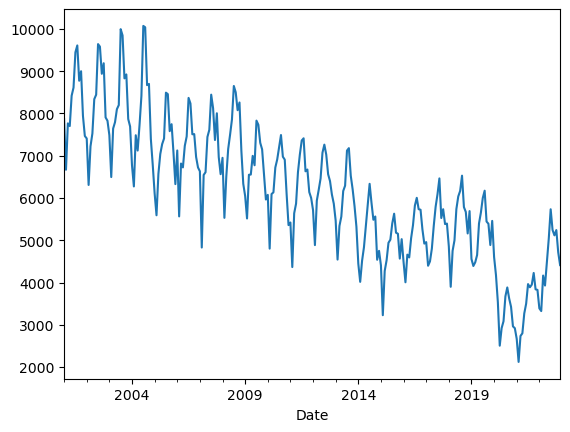

In [9]:
ts = ts['THEFT']
ts.plot();

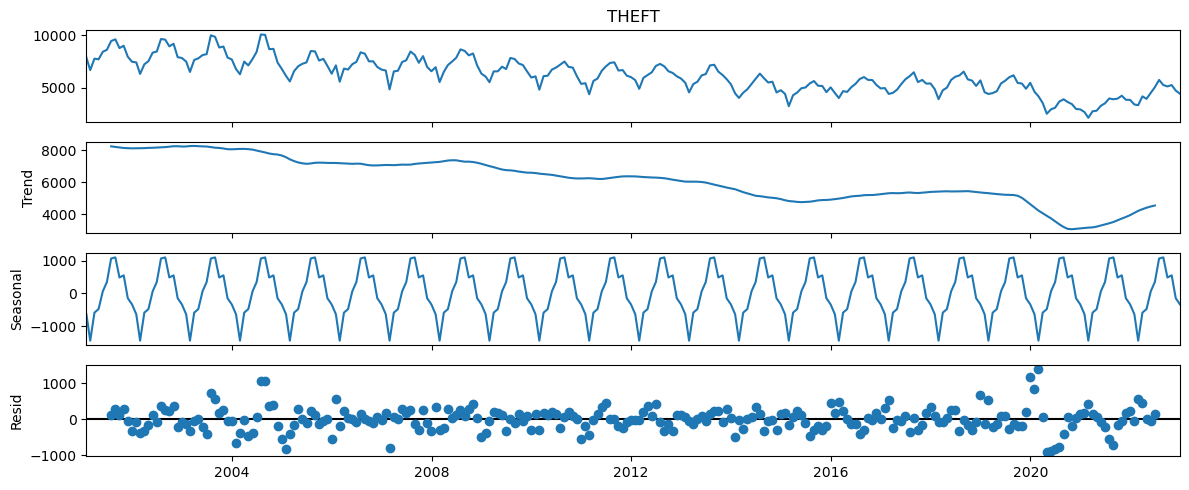

In [10]:
decomp = tsa.seasonal_decompose(ts)
fig = decomp.plot()
fig.set_size_inches(12,5)
fig.tight_layout()

In [11]:
d = ndiffs(ts)
print (f'd = {d}')

d = 1


In [12]:
D = nsdiffs(ts, m =12)
print(f'D = {D}')

D = 0


In [13]:
ts_diff = ts.diff().dropna()

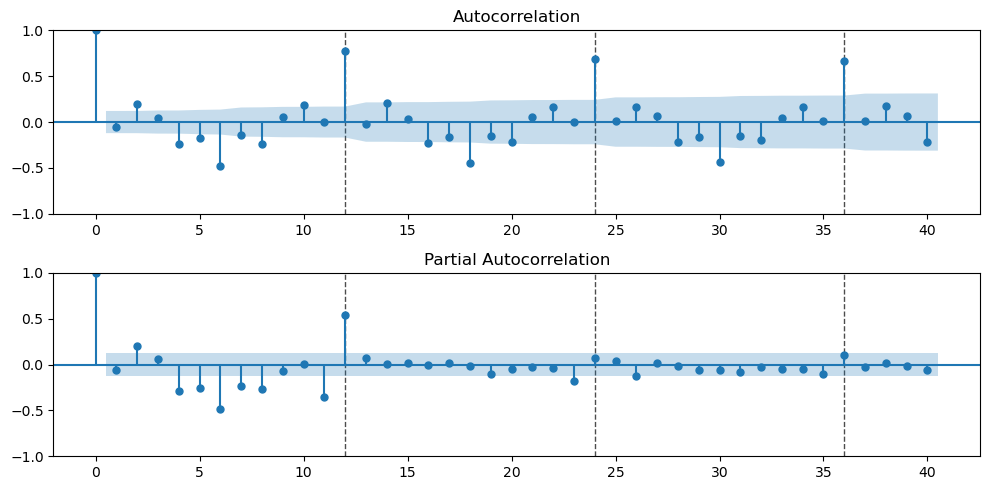

In [16]:
plot_acf_pacf(ts_diff, annotate_seas=True, m = 12);

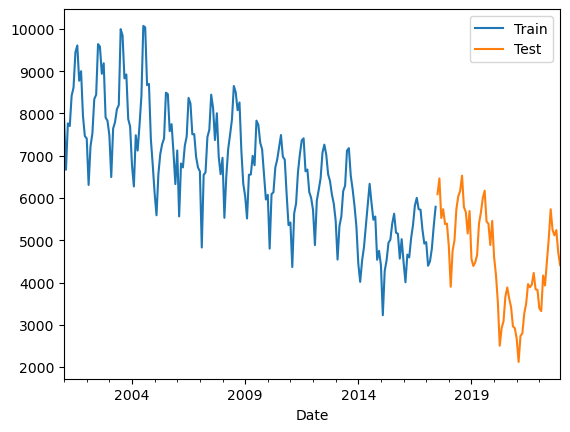

In [17]:
train, test = train_test_split(ts, test_size=.25)
ax = train.plot(label='Train')
test.plot(ax=ax, label='Test')
ax.legend();

In [19]:
# Fitting a SARIMA model

# Orders for non seasonal components
p = 1  # nonseasonal AR
d = 1  # nonseasonal differencing
q = 1  # nonseasonal MA

# Orders for seasonal components
#P = 1  # Seasonal AR
#D = 0  # Seasonal differencing
#Q = 1  # Seasonal MA
#m = 12 # Seasonal period

sarima = tsa.ARIMA(train, order = (p,d,q), seasonal_order=(P,D,Q,m)).fit()

/Users/sofiawang/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/sofiawang/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/sofiawang/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/sofiawang/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 1,001.924
- MSE = 1,836,494.038
- RMSE = 1,355.173
- R^2 = -0.513
- MAPE = 28.83%


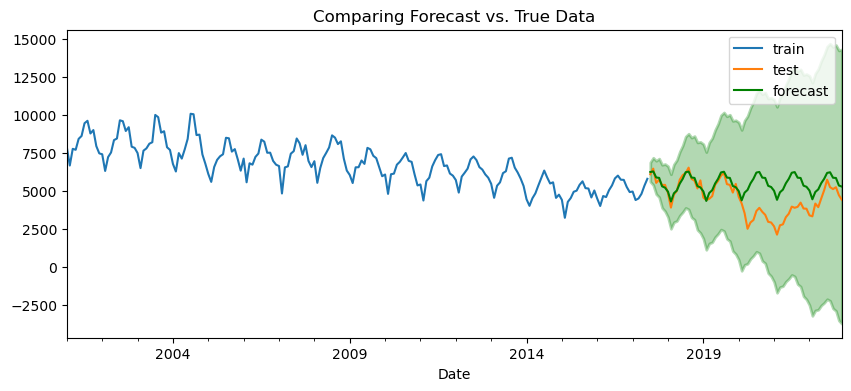

In [24]:
# Obtain summary of forecast as dataframe
forecast_df = sarima.get_forecast(len(test)).summary_frame()

plot_forecast(train, test, forecast_df)

regression_metrics_ts(test, forecast_df["mean"])

In [25]:
sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                     
========================================================================================
Dep. Variable:                            THEFT   No. Observations:                  198
Model:             ARIMA(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood               -1435.746
Date:                          Fri, 23 Feb 2024   AIC                           2881.492
Time:                                  21:51:18   BIC                           2897.908
Sample:                              01-31-2001   HQIC                          2888.137
                                   - 06-30-2017                                         
Covariance Type:                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9986      0.060    -16.517      0.000      -1.117      -0.880
ma.L1          0.9997      0.084     11.968      0.000       0.836       1.163
ar.S.L12       0.9749      0.011     88.026      0.000       0.953       0.997
ma.S.L12      -0.6636      0.063    -10.525      0.000      -0.787      -0.540
sigma2      1.043e+05   1.04e+04     10.015      0.000    8.39e+04    1.25e+05
===================================================================================
Ljung-Box (L1) (Q):                  14.84   Jarque-Bera (JB):                 3.46
Prob(Q):                              0.00   Prob(JB):                         0.18
Heteroskedasticity (H):               0.49   Skew:                             0.08
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

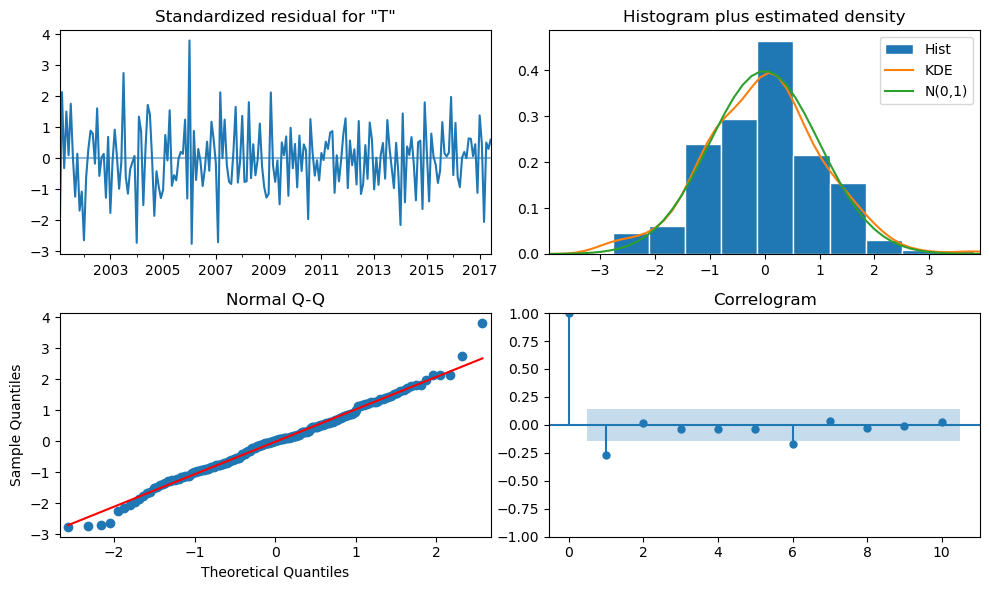

In [26]:
fig = sarima.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout()